In [1]:
import sys
import os

mt_path = os.path.abspath('/home/spacefi1/MT/MT-OpenSTL')
if mt_path not in sys.path:
    sys.path.append(mt_path)

from math import floor

import torch
import matplotlib.pyplot as plt
from openstl.models.fno_model import FNO_Model
torch.manual_seed(1035)
from torch.utils.data import Dataset, DataLoader
from icecream import install
install()
#
#ic.configureOutput(includeContext=True)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

/home/spacefi1/MT/MT-OpenSTL/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class IdentityDataset(Dataset):
    def __init__(self, n):
        """
        Args:
            n (int): Number of samples in the dataset.
        """
        self.n = n  # Total number of samples
        self.data = torch.rand(n, 1, 8)  # Random data with shape (n_samples, channel=1, first_dimension=8)

    def __len__(self):
        # Return the total number of samples
        return self.n

    def __getitem__(self, idx):
        # The input and target are the same (identity function)
        sample = self.data[idx]
        return sample, sample  # Return input and target as identical
    

class DoublingDataset(Dataset):
    def __init__(self, n):
        """
        Args:
            n (int): Number of samples in the dataset.
            a = torch.tensor([[1,2,5],
                        [3,4,5]])
            b = torch.tensor([[2, 2]])
            torch.einsum('ij,ki->ij', a, b)
        """
        self.n = n  # Total number of 
        self.m = 8
        self.data = torch.ones(n, 1, self.m)
        mask = torch.arange(self.m) % 2 == 1
        self.data[:, :, mask] = self.data[:, :, mask] / 2

        self.labels = torch.cat((self.data, self.data), axis=-1)

        self.salt = torch.rand(n)[None, None, :]

        self.data = torch.einsum('ijk,lmi->ijk', self.data, self.salt)
        self.labels = torch.einsum('ijk,lmi->ijk', self.labels, self.salt)
        #self.data = []
        #for _ in range(10):
        #    new_data = torch.randn(n // 10, 1, round(torch.FloatTensor(1).uniform_(4, 16)[0].item()))
        #    ic(new_data.shape)
        #    self.data.append(new_data)
                    

    def __len__(self):
        # Return the total number of samples
        return self.n

    def __getitem__(self, idx):
        # The input and target are the same (identity function)
        
        sample = self.data[idx]
        label = self.labels[idx]
        return sample, label  # Return input and target as identical
    
class WavesDataset(Dataset):
    def __init__(self, n):
        """
        Args:
            n (int): Number of samples in the dataset.
        """
        self.n = n
        self.h, self.w = 8, 8  # Total number of samples
        self.data = torch.ones(n, 1, self.h, self.w)
        mask = torch.arange(self.w) % 2 == 1
        self.data[:, :, :, mask] = self.data[:, :, :, mask] / 2

        #self.labels = torch.ones(n, 1, self.h, self.w)
        #mask = torch.arange(self.h) % 2 == 1
        #self.labels[:, :, mask, :] = self.labels[:, :, mask, :] / 2

        self.salt = torch.rand(n)[None, None, None, :]

        self.data = torch.einsum('ijkl,mnoi->ijkl', self.data, self.salt)
        self.coeff = torch.ones(n)[None, None, None, :] * 2
        self.labels = torch.einsum('ijkl,mnoi->ijkl', self.data, self.coeff)
        #self.labels = torch.einsum('ijkl,mnoi->ijkl', self.labels, self.salt)

    def __len__(self):
        # Return the total number of samples
        return self.n

    def __getitem__(self, idx):
        # The input and target are the same (identity function)
        sample = self.data[idx]
        label = self.labels[idx]
        return sample, label  # Return input and target as identical

In [3]:
in_channels = 1
out_channels = 1
hidden_channels = 64
#shape = (8,)
n_modes = 4
epochs = 41
step_size = 50
gamma = 0.5
lr = 1e-4
freq_print = 10

fno = FNO_Model('skip', n_modes, in_channels, out_channels, hidden_channels, ndim=2)
fno.cuda()
print(f'Model params: {sum(p.numel() for p in fno.parameters() if p.requires_grad)}')

batch = 32
train_size = 10_000
test_size = 200
train_set = WavesDataset(train_size)
test_set = WavesDataset(test_size)
#train_set = IdentityDataset(train_size)
#test_set = IdentityDataset(test_size)
train_loader = DataLoader(train_set, batch_size=batch, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch, shuffle=True)

Model params: 53441


In [4]:
a = next(iter(train_loader))
a[0][0, 0, :, :]

tensor([[0.4273, 0.2136, 0.4273, 0.2136, 0.4273, 0.2136, 0.4273, 0.2136],
        [0.4273, 0.2136, 0.4273, 0.2136, 0.4273, 0.2136, 0.4273, 0.2136],
        [0.4273, 0.2136, 0.4273, 0.2136, 0.4273, 0.2136, 0.4273, 0.2136],
        [0.4273, 0.2136, 0.4273, 0.2136, 0.4273, 0.2136, 0.4273, 0.2136],
        [0.4273, 0.2136, 0.4273, 0.2136, 0.4273, 0.2136, 0.4273, 0.2136],
        [0.4273, 0.2136, 0.4273, 0.2136, 0.4273, 0.2136, 0.4273, 0.2136],
        [0.4273, 0.2136, 0.4273, 0.2136, 0.4273, 0.2136, 0.4273, 0.2136],
        [0.4273, 0.2136, 0.4273, 0.2136, 0.4273, 0.2136, 0.4273, 0.2136]])

In [5]:
a[1][0, 0, :, :]

tensor([[0.8545, 0.4273, 0.8545, 0.4273, 0.8545, 0.4273, 0.8545, 0.4273],
        [0.8545, 0.4273, 0.8545, 0.4273, 0.8545, 0.4273, 0.8545, 0.4273],
        [0.8545, 0.4273, 0.8545, 0.4273, 0.8545, 0.4273, 0.8545, 0.4273],
        [0.8545, 0.4273, 0.8545, 0.4273, 0.8545, 0.4273, 0.8545, 0.4273],
        [0.8545, 0.4273, 0.8545, 0.4273, 0.8545, 0.4273, 0.8545, 0.4273],
        [0.8545, 0.4273, 0.8545, 0.4273, 0.8545, 0.4273, 0.8545, 0.4273],
        [0.8545, 0.4273, 0.8545, 0.4273, 0.8545, 0.4273, 0.8545, 0.4273],
        [0.8545, 0.4273, 0.8545, 0.4273, 0.8545, 0.4273, 0.8545, 0.4273]])

In [6]:
optimizer = torch.optim.AdamW(fno.parameters(), lr=lr, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
loss_func = torch.nn.MSELoss()

for epoch in range(epochs):
    train_mse = 0.0
    for step, (input, target) in enumerate(train_loader):
       input, target = input.cuda(), target.cuda()
       optimizer.zero_grad()
       #ic(target.shape[2:])
       pred = fno(input, target.shape[2:])
       loss = loss_func(pred, target)
       loss.backward()
       optimizer.step()
       train_mse += loss.item()
    train_mse /= len(train_set)
    scheduler.step()

    with torch.no_grad():
        fno.eval()
        test_relative_l2 = 0.0
        for step, (input, target) in enumerate(test_loader):
            input, target = input.cuda(), target.cuda()
            pred = fno(input, target.shape[2:])
            #ic(pred)
            #ic(pred.shape)
            loss = (torch.mean((pred - target) ** 2) / torch.mean(target ** 2)) ** 0.5 * 100
            test_relative_l2 += loss.item()
        test_relative_l2 /= len(test_set)
    
    if epoch % freq_print == 0: print("######### Epoch:", epoch, " ######### Train Loss:", train_mse, " ######### Relative L2 Test Norm:", test_relative_l2)



    

######### Epoch: 0  ######### Train Loss: 0.003915699932436109  ######### Relative L2 Test Norm: 0.06071610748767853
######### Epoch: 10  ######### Train Loss: 2.9324348713544168e-08  ######### Relative L2 Test Norm: 0.0033604430407285692
######### Epoch: 20  ######### Train Loss: 5.217863565611936e-08  ######### Relative L2 Test Norm: 0.004157565571367741
######### Epoch: 30  ######### Train Loss: 1.0452491428658561e-07  ######### Relative L2 Test Norm: 0.0014203966781497002
######### Epoch: 40  ######### Train Loss: 1.5715464336274463e-08  ######### Relative L2 Test Norm: 0.005597985610365868


In [11]:
h, w = 8, 8  # Total number of samples
x = torch.ones(1, 1, h, w)
mask = torch.arange(w) % 2 == 1
x[:, :, :, mask] = x[:, :, :, mask] / 2
x = x.cuda()
#x = x[None, None, :].cuda()
out = fno(x, (64,256))
out

tensor([[[[2.0023, 1.9893, 1.9707,  ..., 1.0319, 1.0136, 1.0011],
          [2.0023, 1.9893, 1.9707,  ..., 1.0319, 1.0136, 1.0011],
          [2.0023, 1.9893, 1.9707,  ..., 1.0319, 1.0136, 1.0011],
          ...,
          [2.0023, 1.9893, 1.9707,  ..., 1.0319, 1.0136, 1.0011],
          [2.0023, 1.9893, 1.9707,  ..., 1.0319, 1.0136, 1.0011],
          [2.0023, 1.9893, 1.9707,  ..., 1.0319, 1.0136, 1.0011]]]],
       device='cuda:0', grad_fn=<ViewBackward0>)

In [12]:
out.shape

torch.Size([1, 1, 64, 256])

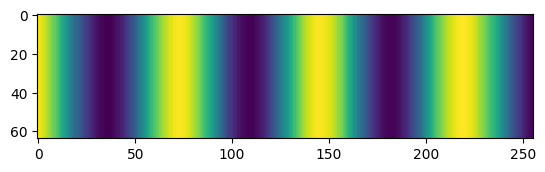

In [13]:
plt.imshow(out.detach().cpu()[0,0,:,:])
plt.show()

In [10]:
out = fno(x, (24,))
out

ValueError: Input and output must have the same number of spatial dimensions, but got input with spatial dimensions of [8, 8] and output size of (10,). Please provide input tensor in (N, C, d1, d2, ...,dK) format and output size in (o1, o2, ...,oK) format.

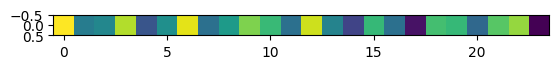

In [ ]:
plt.imshow(out.detach().cpu()[0,:,:])
plt.show()